#  <span style='color:DarkBlue'>P7 - Implémentez un modèle de scoring</span>

<div style="text-align:center">
    <img src="images/logo_proj7_credit.png" width="50%">
</div>

Ce notebook traite du pré processing des jeux de données :

- **application_train/set.csv**,
- **bureau.csv**,
- **bureau_balance.csv**,
- **credit_card_balance.csv**,
- **installments_payments.csv**,
- **POS_CASH_balance.csv**,
- **previous_application.csv**

En particulier :

- **Nettoyage** :
    - **optimisation de la mémoire** en modifiant le type des données. 
    - correction des **valeurs aberrantes**.
    - **imputation** des valeurs manquantes
- **Feature engineering** : dans cette section, nous allons commencer par utiliser les connaissances et les connaissances acquises lors de l'analyse exploratoire des données pour obtenir de bons ensembles de variables en utilisant le feature engineering. Il convient de noter que la plupart des varaibles générées sont basées sur la connaissance du domaine et les expérimentations. Sans de bons ensembles de variibles, les algorithmes d'apprentissage automatique ne peuvent pas produire de résultats efficaces. Nous devrons donc trouver des moyens ingénieux de faire de l'ingénierie des caractéristiques pour que le modèle prenne de meilleures décisions. 
- **Aggregation** : avec les données principales de Home Crédit Group.

***
Sources
***
Les fonctions d'aggrégation ont été reprises du notebook : [Source](https://www.kaggle.com/willkoehrsen/introduction-to-manual-feature-engineering/output) en adaptant la signature pour transmettre le prefix du nom des colonnes et pouvoir passer un dictionnaire des statistiques qu'on souhaite ajouter.

## <span style='background: PowderBlue'>1. Introduction</span>

*****
**Mission**
*****
**Développer un modèle de scoring de la probabilité de défaut de paiement du client** pour étayer la décision d'accorder ou non un prêt à un client potentiel en s’appuyant sur des sources de données variées (données comportementales, données provenant d'autres institutions financières...).

*****
**Objectifs**
*****
- analyser le jeu de données,
- Construire **un modèle de scoring** qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique,
- réaliser un **dashboard interactif** permettant aux chargés de clientèles d'expliquer de manière transparente la décision d'octroi ou non de crédit

*****
**Sources**
*****
- [Jeu de données](https://www.kaggle.com/c/home-credit-default-risk/data)

Le **Kernel Kaggle** utilisé pour l'analyse exploratoire ayant l'EDA le plus de commentaires et effectuant une analyse exploratoire complète sur toutes les fichiers csv mis à notre disposition a été livré par **Rishabh Rao** (Student at -Jaipur, Rajasthan, India).
- [Kernel Kaggle Rishabh Rao](https://www.kaggle.com/rishabhrao/home-credit-default-risk-extensive-eda)

Ce travail est complété par l'auteur par une présentation sur le site medium.com :
[Explications](https://medium.com/thecyphy/home-credit-default-risk-part-1-3bfe3c7ddd7a)

Les fonctions python utilisées pour l'EDA sont extraites du [github](https://github.com/rishabhrao1997/Home-Credit-Default-Risk) et stockées dans la librairie *EDA_KERNEL_FONCTIONS.py*.

In [2]:
# Chargement des librairies
import datetime
import sys
import time
from datetime import datetime
import warnings
#import jyquickhelper
import numpy as np
import pandas as pd
import os
import fonctions_data
#import outils_preprocessing
#import outils_model
#import eda_kernel_fonctions
import pickle

import matplotlib.pyplot as plt

# Modelisation
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Features selection
from collections import Counter
from sklearn.utils import check_random_state
from sklearn.inspection import permutation_importance
import eli5
from eli5.sklearn import PermutationImportance
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.feature_selection import RFECV
from pprint import pprint

# Warnings
warnings.filterwarnings('ignore')

# Versions
print('Version des librairies utilisées :')
#print('jyquickhelper         : ' + jyquickhelper.__version__)
print('Python                : ' + sys.version)
print('NumPy                 : ' + np.version.full_version)
print('Pandas                : ' + pd.__version__)
print('Lightgbm              : ' + lgb.__version__)
now = datetime.now().isoformat()
print('Lancé le           : ' + now)

Version des librairies utilisées :
Python                : 3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]
NumPy                 : 1.24.4
Pandas                : 1.5.3
Lightgbm              : 4.0.0
Lancé le           : 2024-06-15T19:49:18.570800


## <span style='background: PowderBlue'>2. Chargement des datasets nettoyés</span>

In [3]:
# Importation du dataframe train
train_set = pd.read_csv('df_modelisation.csv')

In [4]:
# Importation du dataframe train
test_set = pd.read_csv('df_modelisation_test.csv')

## <span style='background: PowderBlue'>3. Features Selection</span>

### <span style='background:orange'>3.1. Features selection : avec LIGHTGBM</span>

- Extrait du Kernel Kaggle : [Source](https://www.kaggle.com/code/willkoehrsen/introduction-to-feature-selection)- 
Le but est de conserver uniquement les variables les plus pertinentes en utilisant les features importance déterminée par un modèle, Lightgbm dans notre cas.

#### <span style='background:Moccasin'>3.1.1. Train_set/test_set</span>

**Préparation dataframe de travail**

**Avec variables d'importance nulles**

In [5]:
# Description
fonctions_data.detail_type_var(train_set, type_var='all')

SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
type            int64            float64     float64      float64   
nb_nan            0.0                0.0         0.0          0.0   
%_nan             0.0                0.0         0.0          0.0   
count        307507.0           307507.0    307507.0     307507.0   
mean    278181.527256           0.095201    0.341648     0.659894   
std     102790.132982           0.293493    0.474263     0.473745   
min          100002.0                0.0         0.0          0.0   
25%          189146.5                0.0         0.0          0.0   
50%          278203.0                0.0         0.0          1.0   
75%          367143.5                0.0         1.0          1.0   
max          456255.0                1.0         1.0          1.0   

       FLAG_OWN_REALTY CNT_CHILDREN AMT_INCOME_TOTAL AMT_CREDIT AMT_ANNUITY  \
type           float64      float64          float64    float64     float64   
nb_nan             0.0          0.0              0.0        0.0         0.0   
%_nan              0.0          0.0              0.0        0.0         0.0   
count         307507.0     307507.0         307507.0   307507.0    307507.0   
mean          0.306331     0.021954         0.001224   0.138343    0.099422   
std            0.46097     0.038011         0.002027   0.100505    0.056524   
min                0.0          0.0              0.0        0.0         0.0   
25%                0.0          0.0         0.000742    0.05618     0.05814   
50%                0.0          0.0         0.001039      0.117      0.0908   
75%                1.0      0.05264         0.001512     0.1907      0.1287   
max                1.0          1.0              1.0        1.0         1.0   

       REGION_POPULATION_RELATIVE  ...  \
type                      float64  ...   
nb_nan                        0.0  ...   
%_nan                         0.0  ...   
count                    307507.0  ...   
mean                     0.284957  ...   
std                      0.191535  ...   
min                           0.0  ...   
25%                        0.1346  ...   
50%                        0.2568  ...   
75%                        0.3928  ...   
max                           1.0  ...   

       BUREAU_CREDIT_TYPE_LOAN_FOR_WORKING_CAPITAL_REPLENISHMENT_MEAN  \
type                                              float64               
nb_nan                                                0.0               
%_nan                                                 0.0               
count                                            307507.0               
mean                                             0.000197               
std                                              0.008131               
min                                                   0.0               
25%                                                   0.0               
50%                                                   0.0               
75%                                                   0.0               
max                                                   1.0               

       BUREAU_CREDIT_TYPE_MICROLOAN_SUM BUREAU_CREDIT_TYPE_MICROLOAN_MEAN  \
type                            float64                           float64   
nb_nan                              0.0                               0.0   
%_nan                               0.0                               0.0   
count                          307507.0                          307507.0   
mean                           0.029284                          0.003605   
std                            0.448622                          0.042823   
min                                 0.0                               0.0   
25%                                 0.0                               0.0   
50%                                 0.0                               0.0   
75%                                 0.0                               0.0   
max 

In [22]:
# Dataframes de travail
train_lgbm = train_set.copy()
print(f'train_lgbm : {train_lgbm.shape}')
test_lgbm = test_set.copy()
print(f'test_lgbm : {test_lgbm.shape}')

train_lgbm : (307507, 530)
test_lgbm : (48744, 515)


In [23]:
# Sauvegarde des étiquettes car l'alignement supprimera
# cette variable.
train_lgbm_labels = train_lgbm['TARGET']

# Sauvegarde des identifiants
train_lgbm_ids = train_lgbm['SK_ID_CURR']
test_lgbm_ids = test_lgbm['SK_ID_CURR']

# Alignement des dataframes (suppression variable TARGET)
train_lgbm, test_lgbm = \
    train_lgbm.align(test_lgbm, join='inner', axis=1)

# Suppression des identifiants (variable non utile pour les variables
# pertinentes)
train_lgbm = train_lgbm.drop(columns=['SK_ID_CURR'])
test_lgbm = test_lgbm.drop(columns=['SK_ID_CURR'])

print(f'train_lgbm : {train_lgbm.shape}')
print(f'test_lgbm : {test_lgbm.shape}')

train_lgbm : (307507, 276)
test_lgbm : (48744, 276)


**Modélisation**

In [24]:
# Initialiser un tableau vide pour contenir les features importance
feature_importances = np.zeros(train_lgbm.shape[1])

# Create the model with several hyperparameters
model = lgb.LGBMClassifier(objective='binary',
                           boosting_type='goss',
                           n_estimators=10000,
                           class_weight='balanced',
                           verbose = 200,
                           early_stopping_rounds = 100)

In [25]:
# Entraînement du modèle deux fois pour éviter l'overfitting
for i in range(2):

    # Split en jeux d'entraînement et de validation
    train_features, valid_features, train_y, valid_y = train_test_split(train_lgbm, train_lgbm_labels,
                         test_size=0.25, random_state=i)

    # Entraînement en utilisant early stopping
    model.fit(train_features, train_y,
          eval_set=[(valid_features, valid_y)],
          eval_metric='auc')

    # Sauvegarde des features importances
    feature_importances += model.feature_importances_

[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 18668, number of negative: 211962
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.867529
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.506409
[LightGBM] [Debug] init for col-wise cost 0.110860 seconds, init for row-wise cost 0.305426 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.170676 seconds.
Y

In [26]:
# Assurez-vous de faire la moyenne des features importance !
# puisque le modèle a été entraîné 2 fois
feature_importances = feature_importances / 2
df_lightgbm = \
    pd.DataFrame({'feature': list(train_lgbm.columns),
                  'importance': feature_importances}) \
    .sort_values('importance', ascending=False)

df_lightgbm.head()

feature  importance
60  CREDIT_TO_ANNUITY_RATIO       195.0
27             EXT_SOURCE_3       165.5
25             EXT_SOURCE_1       163.5
26             EXT_SOURCE_2       157.5
9                DAYS_BIRTH       129.5

In [27]:
# Exploration des variables avec zéro importance
zero_features = \
    list(df_lightgbm[df_lightgbm['importance'] == 0.0][
        'feature'])
print(f'{len(zero_features)} variables avec 0.0 importance :\n')
zero_features

36 variables avec 0.0 importance :



['FLAG_MOBIL',
 'CC_CNT_DRAWINGS_OTHER_CURRENT_MAX',
 'FLAG_EMP_PHONE',
 'OCCUPATION_TYPE_PRIVATESERVICESTAFF',
 'CC_CNT_DRAWINGS_CURRENT_MIN',
 'FLAG_CONT_MOBILE',
 'CC_CNT_DRAWINGS_OTHER_CURRENT_MEAN',
 'OCCUPATION_TYPE_HRSTAFF',
 'CC_AMT_DRAWINGS_OTHER_CURRENT_MIN',
 'PREV_CODE_REJECT_REASON_XNA_MEAN',
 'POS_LATE_PAYMENT_MAX',
 'CC_AMT_DRAWINGS_ATM_CURRENT_MIN',
 'PREV_NAME_CONTRACT_TYPE_XNA_MEAN',
 'PREV_NAME_CLIENT_TYPE_XNA_MEAN',
 'OCCUPATION_TYPE_COOKINGSTAFF',
 'NAME_HOUSING_TYPE_COOPAPARTMENT',
 'FLAG_DOCUMENT_4',
 'FLAG_DOCUMENT_6',
 'WEEKDAY_APPR_PROCESS_START_TUESDAY',
 'HOUSETYPE_MODE_SPECIFICHOUSING',
 'HOUSETYPE_MODE_TERRACEDHOUSE',
 'PREV_RATE_INTEREST_PRIVILEGED_MEAN',
 'PREV_DAYS_FIRST_DRAWING_MAX',
 'NAME_TYPE_SUITE_NAN',
 'NAME_TYPE_SUITE_GROUPOFPEOPLE',
 'NAME_TYPE_SUITE_CHILDREN',
 'OCCUPATION_TYPE_ITSTAFF',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'WALLSMATERIAL_MODE_MIXED',
 'OCCUPATION_TYPE_SECRETARIES',
 'WALLSMATERIAL_MODE_MONOLITHIC',
 'WALLSMATERIAL_MODE_OTHERS',
 '

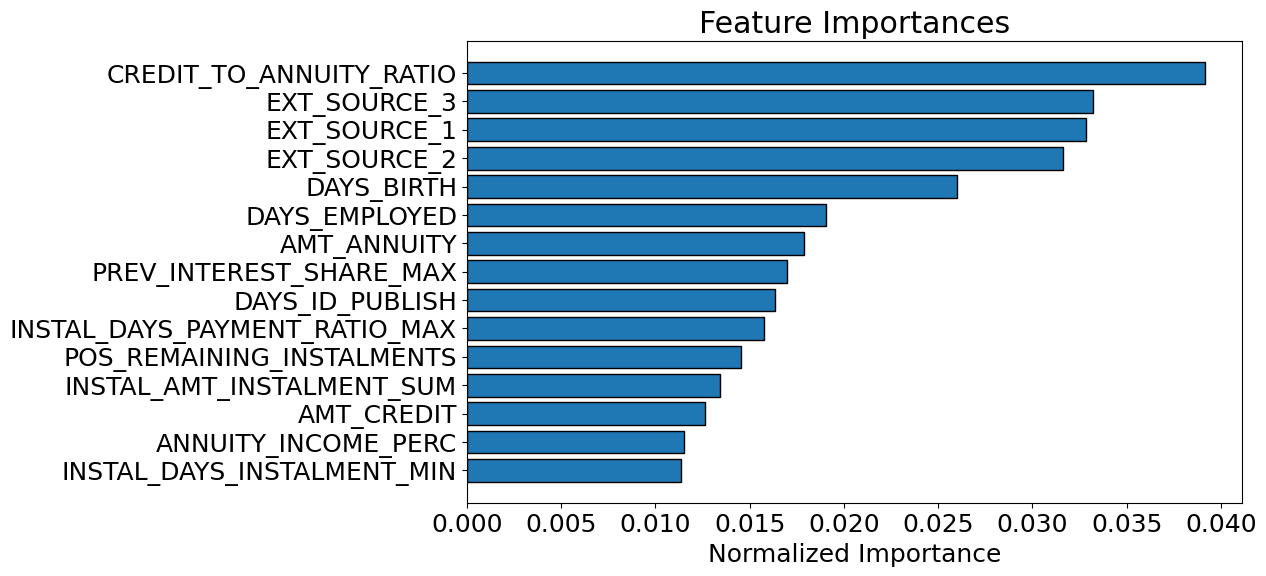

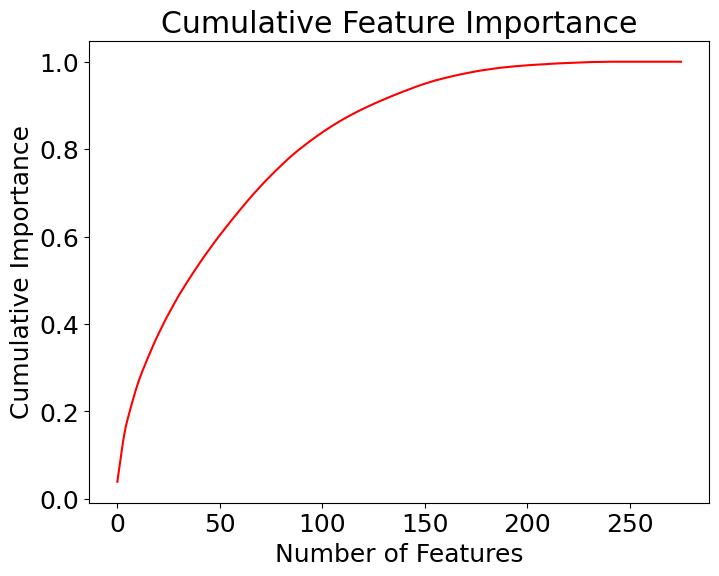

125 features required for 0.90 of cumulative importance


In [31]:
# Affichage des variables les plus importantes normalisées déterminée
# par Lightgbm
df_lightgbm_norm = fonctions_data.plot_feature_importances(df_lightgbm)

In [32]:
# Suppression des variables avec zéro importance
train_lgbm = train_lgbm.drop(columns=zero_features)
test_lgbm = test_lgbm.drop(columns=zero_features)

print(f'train_lgbm : {train_lgbm.shape}')
print(f'test_lgbm : {test_lgbm.shape}')

train_lgbm : (307507, 240)
test_lgbm : (48744, 240)


**Sans variables d'importance nulles**

In [36]:
# Repasser une fois le modèle pour voir si lightgbm retrouve des 0 importance
zero_features_2, df_lightgbm_2 = fonctions_data.identify_zero_importance_features(train_lgbm,
                                       train_lgbm_labels)

[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 18668, number of negative: 211962
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.845624
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.459870
[LightGBM] [Debug] init for col-wise cost 0.174459 seconds, init for row-wise cost 0.560921 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.644899 seconds.
Y

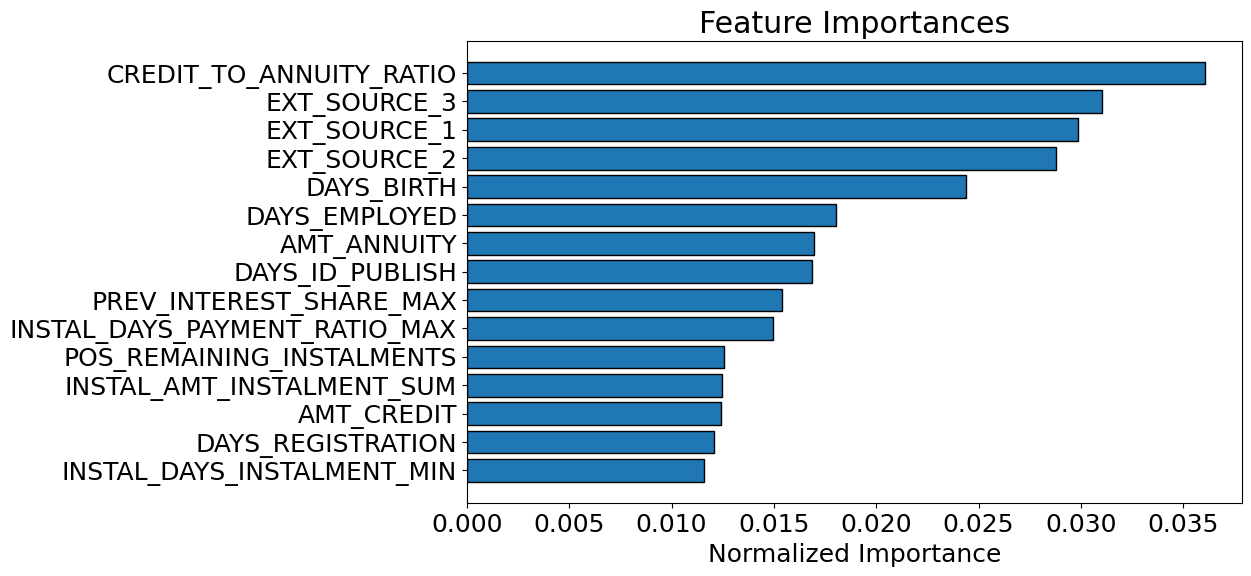

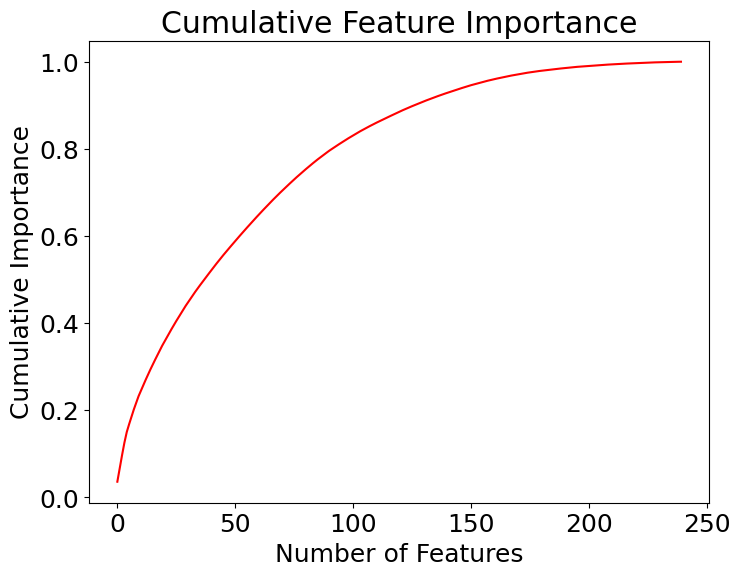

127 features required for 0.90 of cumulative importance


In [37]:
# Affichage des variables les plus importantes normalisées déterminée
# par Lightgbm
df_lightgbm_norm_2 = fonctions_data.plot_feature_importances(df_lightgbm_2)

**Sauvegarde du modèle généré (sans variables d'importances nulles)**

In [39]:
# Sauvegarde des features importances avec lightgbm
fic_sav_lightgbm = \
    'pickle_files/lightgbm.pickle'
with open(fic_sav_lightgbm, 'wb') as f:
    pickle.dump(df_lightgbm_2, f, pickle.HIGHEST_PROTOCOL)

**Chargement du dataframe sauvegardé**

In [41]:
# Chargement des features importance de ligthgbm
fic_sav_lightgbm = \
    'pickle_files/lightgbm.pickle'
# Chargement des features importance
with open(fic_sav_lightgbm, 'rb') as df_lightgbm:
    df_lightgbm = pickle.load(df_lightgbm)
df_lightgbm.shape

(240, 2)

In [45]:
# Sauvegarde du nombre de features importance
df_train_set = pd.DataFrame({})
df_train_set = fonctions_data.tracer_features_importance(df_lightgbm , df_train_set, 'train_sans_set' , 'lightgbm')

train_sans_set - lightgbm : 240 variables importantes conservées


### <span style='background:orange'>3.2. Features selection : avec permutation importance</span>

#### <span style='background:Moccasin'>3.2.1. Train_set/test_set</span>

**Préparation du dataframe**

In [30]:
# Dataframes de travail
train_fs_perm = train_set.copy()
print(f'train_fs_perm : {train_fs_perm.shape}')

train_fs_perm : (307507, 530)


In [31]:
# Sauvegarde des étiquettes
train_fs_perm_labels = train_fs_perm['TARGET']

# Suppression des identifiants (variable non utile pour les variables
# pertinentes)
train_fs_perm = train_fs_perm.drop(columns=['SK_ID_CURR'])
train_fs_perm = train_fs_perm.drop(columns=['TARGET'])

print(f'train_fs_perm : {train_fs_perm.shape}')

train_fs_perm : (307507, 528)


In [32]:
# Initialisation des variables
X = train_fs_perm
y = train_fs_perm_labels

In [33]:
# Create the model with several hyperparameters
lgbm = lgb.LGBMClassifier(objective = 'binary',
                          data_sample_strategy = 'goss',
                          n_estimators=10000,
                          class_weight='balanced',
                          early_stopping_rounds=100,
                          verbose=200)

In [34]:
# Split en jeux d'entraînement et de validation
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.25, random_state=21)

# Entraînement en utilisant early stopping
lgbm.fit(X_train, y_train,
         eval_set=[(X_test, y_test)],
         eval_metric='auc')

[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Info] Number of positive: 18702, number of negative: 211928
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.906174
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.640606
[LightGBM] [Debug] init for col-wise cost 0.211751 seconds, init for row-wise cost 0.457007 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.532338 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 50115
[LightGBM] [Info] Number of data points in the train set: 230630, number of used features: 499
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.

LGBMClassifier(class_weight='balanced', data_sample_strategy='goss',
               early_stopping_rounds=100, n_estimators=10000,
               objective='binary', verbose=200)

<span style='background:mistyrose'>**Permutation-based Importance avec sklearn**</span>

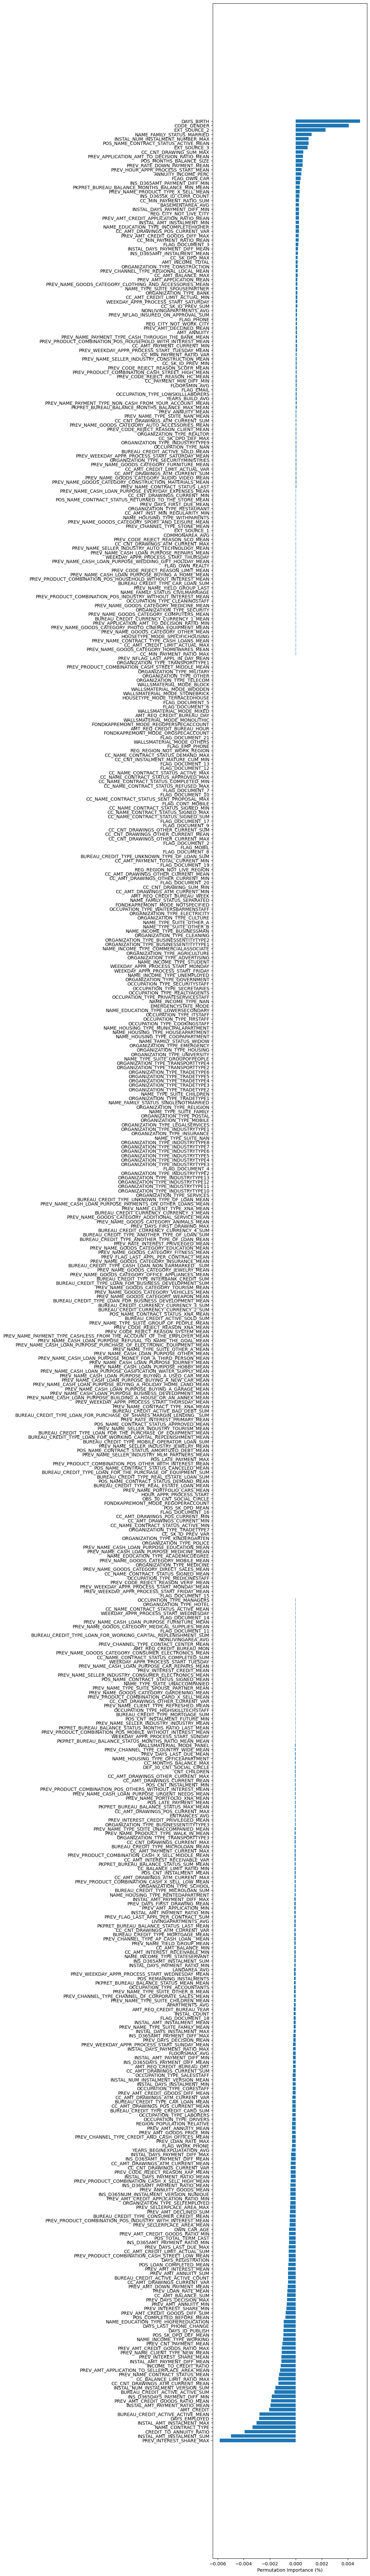

In [37]:
# Feature importance par permutation importance avec sklearn
perm_imp_sklearn = fonctions_data.plot_permutation_importance(lgbm, X_test, y_test, figsize=(6, 100))

In [38]:
# Constitution du dataframe de travail
df_fs_perm_imp_sklearn = \
    pd.DataFrame({'Variables': X_test.columns,
                  'Importance': perm_imp_sklearn.importances_mean,
                  'Importance_abs': np.abs(perm_imp_sklearn.importances_mean)})

In [39]:
# Variables sans zéros importances
fs_perm_imp_sklearn = df_fs_perm_imp_sklearn[df_fs_perm_imp_sklearn[
    'Importance_abs'] != 0.000]
print(f'{fs_perm_imp_sklearn.shape[0]} variables sans zéro importance')

344 variables sans zéro importance


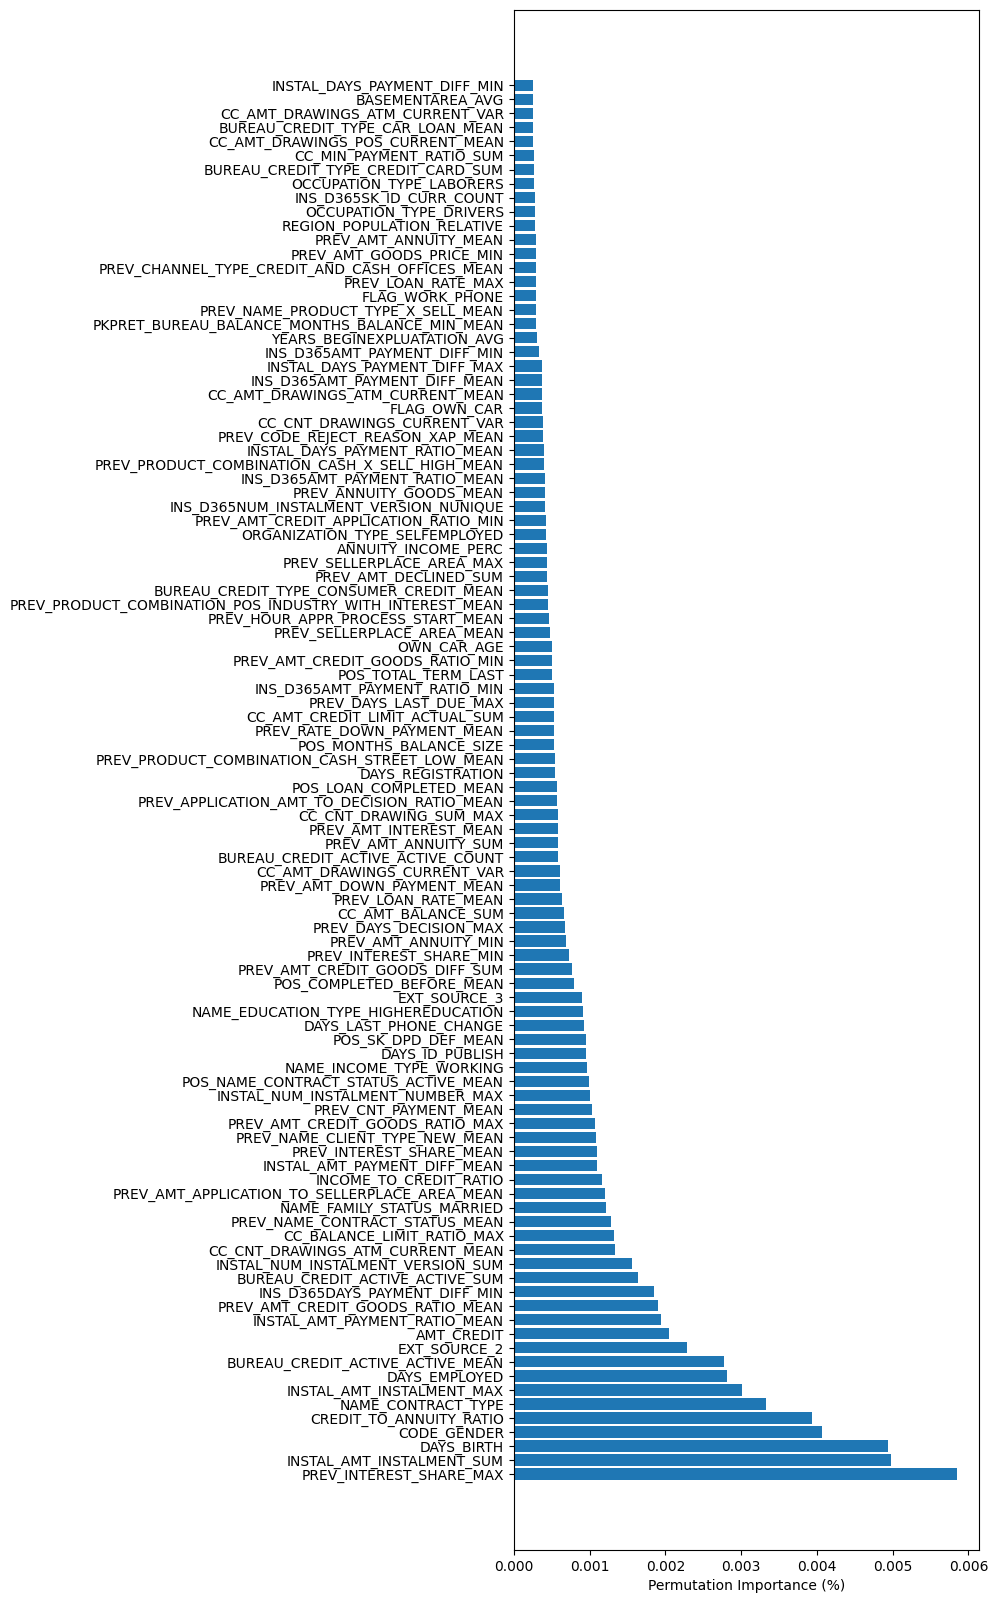

In [40]:
# Affichage des 100 variables les plus importantes
df_fs_perm_imp_sklearn_plot = \
    df_fs_perm_imp_sklearn.sort_values(by='Importance_abs',
                                       ascending=False)

plt.figure(figsize=(6, 20))
plt.barh(df_fs_perm_imp_sklearn_plot['Variables'].head(100),
         df_fs_perm_imp_sklearn_plot['Importance_abs'].head(100))
plt.xlabel("Permutation Importance (%)")
plt.show()

In [41]:
df_fs_perm_imp_sklearn = pd.DataFrame(fs_perm_imp_sklearn['Variables'])
df_fs_perm_imp_sklearn.shape[0]

344

**Sauvegarde**

In [21]:
# Sauvegarde des features importances avec permutation importance sklearn
fic_sav_perm_imp_sklearn_lgbm = \
    'pickle_files/perm_imp_sklearn.pickle'
with open(fic_sav_perm_imp_sklearn_lgbm, 'wb') as f:
    pickle.dump(perm_imp_sklearn, f, pickle.HIGHEST_PROTOCOL)

In [22]:
# Sauvegarde des features importances avec permutation importance sklearn
fic_sav_fs_perm_imp_sklearn_lgbm = \
    'pickle_files/fs_perm_imp_sklearn.pickle'
with open(fic_sav_fs_perm_imp_sklearn_lgbm, 'wb') as f:
    pickle.dump(df_fs_perm_imp_sklearn, f, pickle.HIGHEST_PROTOCOL)

**Chargement du dataframe sauvegardé**

In [42]:
# Chargement des features importance de sklearn perm imp
fic_sav_fs_perm_imp_sklearn = \
    'pickle_files/fs_perm_imp_sklearn.pickle'
# Chargement des features importance
with open(fic_sav_fs_perm_imp_sklearn, 'rb') as df_fs_perm_imp_sklearn:
    df_fs_perm_imp_sklearn = pickle.load(df_fs_perm_imp_sklearn)
df_fs_perm_imp_sklearn.shape

(343, 1)

In [45]:
# Sauvegarde du nombre de features importance
df_fs_train_set = pd.DataFrame({})
df_fs_train_set = fonctions_data.tracer_features_importance(df_fs_perm_imp_sklearn,
                                df_fs_train_set,
                                'train_set',
                                'permutation-importance-LightGbm')

train_set - permutation-importance-LightGbm : 343 variables importantes conservées


<span style='background:mistyrose'>**Permutation importance avec eli5**</span>

In [46]:
# Feature importance par permutation importance avec avec librairie eli5
perm_imp_eli5 = fonctions_data.plot_permutation_importance_eli5(lgbm, X_test,
                                                          y_test)

In [47]:
# Constitution du dataframe de travail
df_fs_perm_imp_eli5 = \
    pd.DataFrame({'Variables': X_test.columns,
                  'Importance': perm_imp_eli5.feature_importances_,
                  'Importance_abs':
                  np.abs(perm_imp_eli5.feature_importances_)})

In [48]:
# Variables sans zéros importances
fs_perm_imp_eli5 = df_fs_perm_imp_eli5[df_fs_perm_imp_eli5[
    'Importance_abs'] != 0.0000]
print(f'{fs_perm_imp_eli5.shape[0]} variables sans zéro importance')

340 variables sans zéro importance


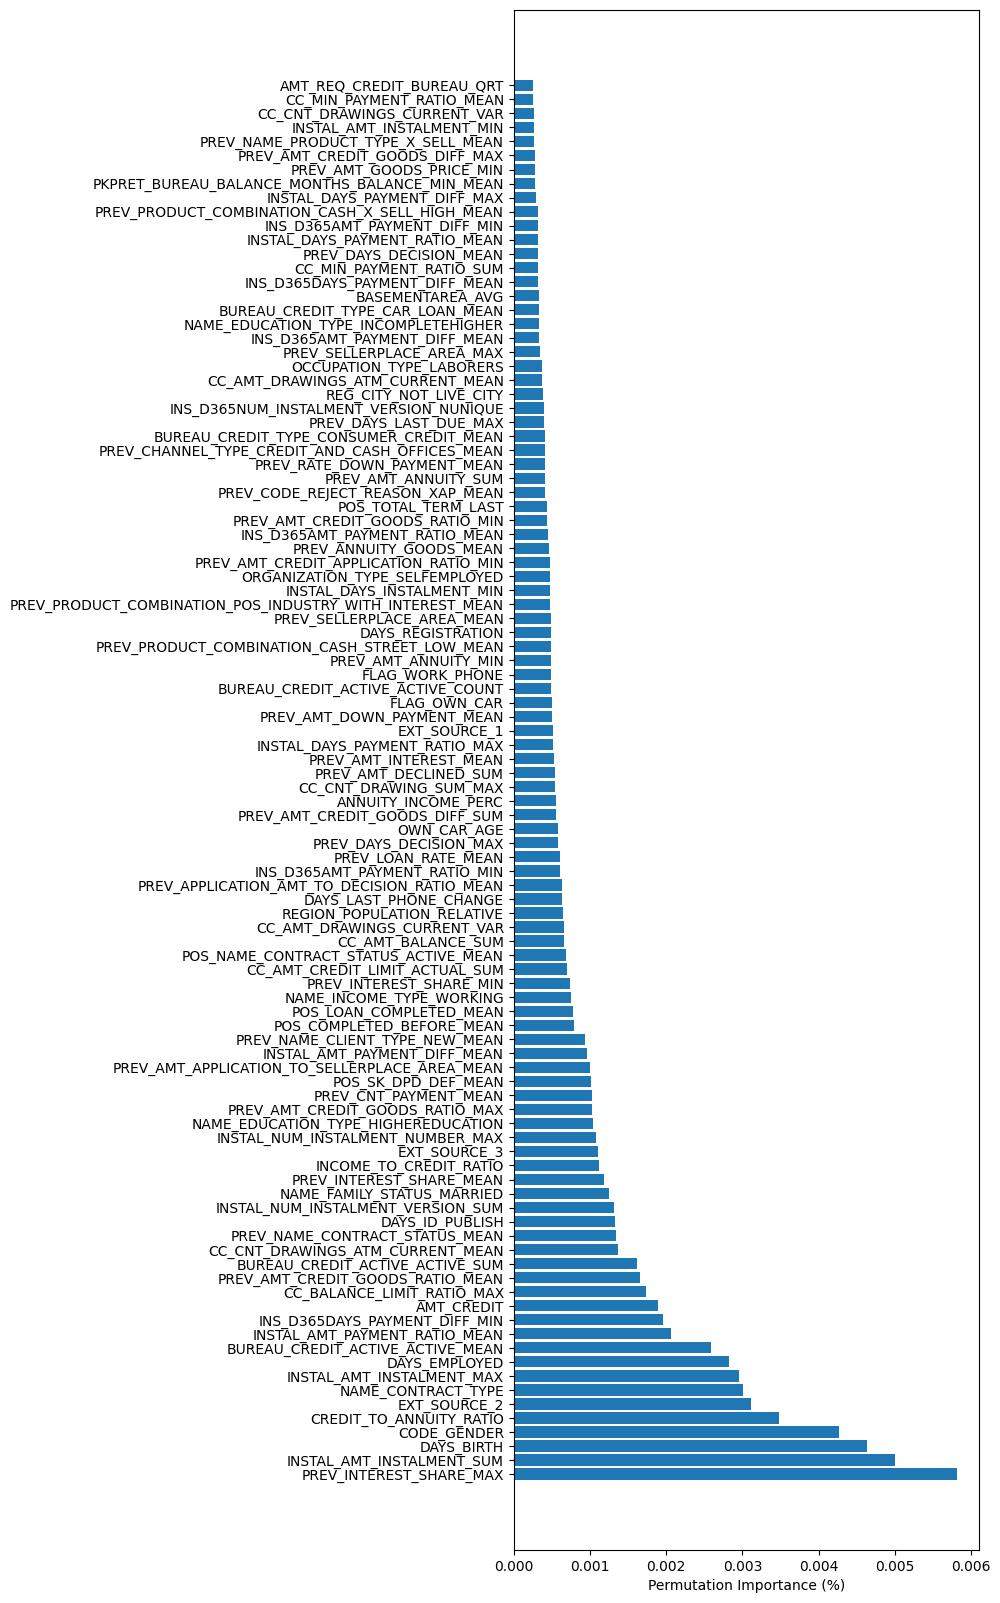

In [49]:
# Affichage des 100 variables les plus importantes
df_fs_perm_imp_eli5_plot = \
    df_fs_perm_imp_eli5.sort_values(by='Importance_abs',
                                    ascending=False)

plt.figure(figsize=(6, 20))
plt.barh(df_fs_perm_imp_eli5_plot['Variables'].head(100),
         df_fs_perm_imp_eli5_plot['Importance_abs'].head(100))
plt.xlabel("Permutation Importance (%)")
plt.show()

**Sauvegarde**

In [40]:
# Sauvegarde des features importances avec permutation importance eli5
fic_sav_fs_perm_imp_eli5_lgbm = \
    'pickle_files/fs_perm_imp_eli5.pickle'
with open(fic_sav_fs_perm_imp_eli5_lgbm, 'wb') as f:
    pickle.dump(df_fs_perm_imp_eli5, f, pickle.HIGHEST_PROTOCOL)

**Chargement du dataframe sauvegardé**

In [41]:
# Chargement des features importance de eli5
fic_sav_fs_perm_imp_eli5 = \
    'pickle_files/fs_perm_imp_eli5.pickle'
# Chargement des features importance
with open(fic_sav_fs_perm_imp_eli5, 'rb') as df_fs_perm_imp_eli5:
    df_fs_perm_imp_eli5 = pickle.load(df_fs_perm_imp_eli5)
df_fs_perm_imp_eli5.shape

(528, 3)

In [50]:
# Sauvegarde du nombre de features importance
df_fs_train_set = pd.DataFrame({})
df_fs_train_set = tracer_features_importance(df_fs_perm_imp_eli5,
                                df_fs_train_set,
                                'train_imp2_set',
                                'permutation-importance-eli5')

train_imp2_set - permutation-importance-eli5 : 528 variables importantes conservées


## <span style='background: PowderBlue'>4. Bilan: Datasets Finaux</span>

#### <span style='background:mistyrose'>Train_set/test_set</span>

Les différents dataframes des variables avec hautes importances avec les features importance d'un modèle Lightgbm ou RandomForest, les permutations importances avec les librairies scikit-learn ou eli5 pour le jeu de données train set sont :

- df_fs_lightgbm
- df_fs_perm_imp_sklearn- 
df_fs_perm_imp_eli,

**Redondance des variables conservées: test sur les variables les plus sélectionnées par feature selection**

In [51]:
# Récupération des variables conservées pour chaque feature selection
liste_var = df_lightgbm['feature'].to_list()
print(len(liste_var))
liste_var.extend(df_fs_perm_imp_sklearn['Variables'].to_list())
print(len(liste_var))
liste_var.extend(df_fs_perm_imp_eli5['Variables'].to_list())
print(len(liste_var))

276
619
1147


In [52]:
# Nomre de répétitions de chacune des variables
dico_nbre_repet_var = Counter(liste_var)
len(dico_nbre_repet_var)

528

In [53]:
df_nbr_repet_var = pd.DataFrame.from_dict(dico_nbre_repet_var,
                                          orient='index',
                                          columns=['Nbr_repetition'])\
    .reset_index().rename(columns={'index':'Variables'}) \
    .sort_values(by='Nbr_repetition', ascending=False)

df_nbr_repet_var.style.hide_index()

In [57]:
# Plage de nombre de répétitions
liste_bins = [0, 1, 2, 3, 4, 5, 6, 7, 8]
fonctions_data.distribution_variables_plages(df_nbr_repet_var,
                                          'Nbr_repetition',
                                          liste_bins)

In [65]:
# Les variables présentes plus de 2 fois pour les 3 méthodes de feature
#  sélection seront conservées
var_cons_train_set = \
    df_nbr_repet_var[df_nbr_repet_var['Nbr_repetition'] >= 3][
        'Variables'].to_list()
print(f'{len(var_cons_train_set)} variables conservées pour le train_set')
var_cons_train_set

216 variables conservées pour le train_set


['CREDIT_TO_ANNUITY_RATIO',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'INSTAL_AMT_PAYMENT_DIFF_MIN',
 'POS_CNT_INSTALMENT_MIN',
 'PREV_WEEKDAY_APPR_PROCESS_START_SUNDAY_MEAN',
 'PREV_DAYS_FIRST_DRAWING_MEAN',
 'CC_AMT_DRAWINGS_ATM_CURRENT_MEAN',
 'PREV_APPLICATION_AMT_TO_DECISION_RATIO_MIN',
 'PREV_AMT_APPLICATION_MIN',
 'CC_AMT_DRAWINGS_ATM_CURRENT_VAR',
 'INS_D365AMT_PAYMENT_DIFF_MAX',
 'CC_AMT_DRAWINGS_CURRENT_VAR',
 'PREV_CODE_REJECT_REASON_SCO_MEAN',
 'OCCUPATION_TYPE_CORESTAFF',
 'PREV_NAME_PORTFOLIO_XNA_MEAN',
 'FLAG_DOCUMENT_18',
 'CC_AMT_DRAWINGS_ATM_CURRENT_SUM',
 'FLAG_WORK_PHONE',
 'NONLIVINGAPARTMENTS_AVG',
 'CC_AMT_DRAWINGS_ATM_CURRENT_MAX',
 'PREV_CODE_REJECT_REASON_LIMIT_MEAN',
 'CC_CNT_DRAWINGS_ATM_CURRENT_SUM',
 'INS_D365NUM_INSTALMENT_VERSION_NUNIQUE',
 'FLAG_PHONE',
 'WALLSMATERIAL_MODE_PANEL',
 'PREV_CODE_REJECT_REASON_CLIENT_MEAN',
 'CC_MIN_PAYMENT_RATIO_SUM',
 'PREV_CODE_REJECT_REASON_HC_MEAN',
 'CC_CNT_DRAWINGS_CURRENT_MAX',
 'PREV_WEEKDAY_APP

In [66]:
# Sauvegarde des variables conservées pour le train_set
fic_sav_var_cons_train_set = \
    'pickle_files/var_cons_train_set.pickle'
with open(fic_sav_var_cons_train_set, 'wb') as f:
    pickle.dump(var_cons_train_set, f, pickle.HIGHEST_PROTOCOL)

In [67]:
# Chargement des variables conservées pour le train_set
fic_sav_var_cons_train_set = \
    'pickle_files/var_cons_train_set.pickle'
with open(fic_sav_var_cons_train_set, 'rb') as df_var_cons_train_set:
    var_cons_train_set = pickle.load(df_var_cons_train_set)
len(var_cons_train_set)

216

**Rassemblement des dataframes train_set et test_set finaux**

In [68]:
# Constitution du train_set
print(f'{train_set.shape}')
# Ajout de l'identifiant du client et de la variable cible
var_cons_train_set_avec_target_id = ['SK_ID_CURR', 'TARGET']
var_cons_train_set_avec_target_id.extend(var_cons_train_set)
train_set = train_set[var_cons_train_set_avec_target_id]
print(f'{train_set.shape}')

(307507, 530)
(307507, 218)


In [69]:
# Constitution du test_set
print(f'{test_set.shape}')
# Ajout de l'identifiant du client
var_cons_train_set_avec_id = ['SK_ID_CURR']
var_cons_train_set_avec_id.extend(var_cons_train_set)
test_set = test_set[var_cons_train_set_avec_id]
print(f'{test_set.shape}')

(48744, 515)
(48744, 217)


**Sauvegarde**

In [72]:
# Sauvegarde du train_set après nettoyage, feature engineering et
# feature selection
fic_sav_train_set = \
    'pickle_files/train_set.pickle'
with open(fic_sav_train_set, 'wb') as f:
    pickle.dump(train_set, f, pickle.HIGHEST_PROTOCOL)

In [73]:
# Export en fichier .csv
train_set.to_csv('train_set.csv',
                                  index=False)

In [74]:
# Sauvegarde du test_set après nettoyage, feature engineering et
# feature selection
fic_sav_test_set = \
    'pickle_files/test_set.pickle'
with open(fic_sav_test_set, 'wb') as f:
    pickle.dump(test_set, f, pickle.HIGHEST_PROTOCOL)

In [75]:
# Export en fichier .csv
test_set.to_csv('test_set.csv',
                                 index=False)

--------------------------------------------------------------------------------------------------------------------------------------------------

Les jeux de données sont nettoyés, encodés, features engineering et features sélection effectués. Les données sont prêtes pour la partie Machine Learning traitée dans le notebook P7_05_MODELISATION.ipynb.

---------------------------------------------------------------------------------------------------------------------------------------------------